In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

# 1. loading
df = pd.read_csv("/Users/fengxiaotong/Desktop/CS 559 FINAL/train_data.csv")
df = df.rename(columns=lambda x: x.strip())

# 2. dependent and independent
df = df.rename(columns=lambda x: x.strip())
X_raw = df.drop(columns=["Index", "Bankrupt?"])
y = df["Bankrupt?"]

# 3. standard
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
# 4. Gaussian
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pd.DataFrame(pt.fit_transform(X_scaled), columns=X_raw.columns)


In [2]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_transformed, y)
importances = rf.feature_importances_
top_60_idx = np.argsort(importances)[-60:]
top_60_features = X_transformed.columns[top_60_idx]
X_top = X_transformed[top_60_features]

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

vif_df = calculate_vif(X_top)
vif_df = vif_df.set_index("feature")
vif_df = vif_df.replace([np.inf, -np.inf], np.nan).dropna()
valid_features = vif_df[vif_df["VIF"] < 10].index.tolist()
X_filtered = X_top[valid_features]

X_final = X_filtered.iloc[:, :50] if X_filtered.shape[1] > 50 else X_filtered

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [3]:
# 4.pick the best number of Cluster
range_n_clusters = range(2, 11)
best_score = -1
best_n_clusters = 2

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=5, max_iter=100)
    labels = kmeans.fit_predict(X_final)
    score = silhouette_score(X_final, labels)
    if score > best_score:
        best_score = score
        best_n_clusters = n

print(f"best number: {best_n_clusters} Silhouette Score: {best_score:.4f}")

best number: 7 Silhouette Score: 0.1740


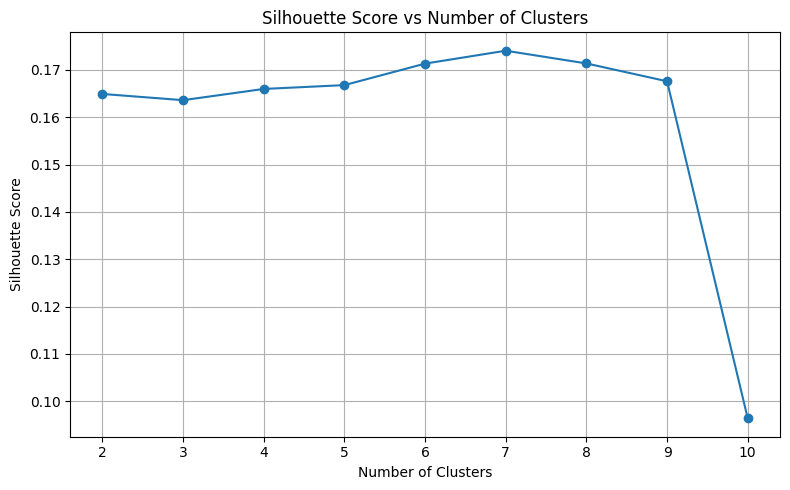

best number: 7, Silhouette Score = 0.1740


In [4]:
import matplotlib.pyplot as plt

range_n_clusters = range(2, 11)
silhouette_scores = []

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=5, max_iter=100)
    labels = kmeans.fit_predict(X_final)
    score = silhouette_score(X_final, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# best number
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"best number: {best_n_clusters}, Silhouette Score = {max(silhouette_scores):.4f}")


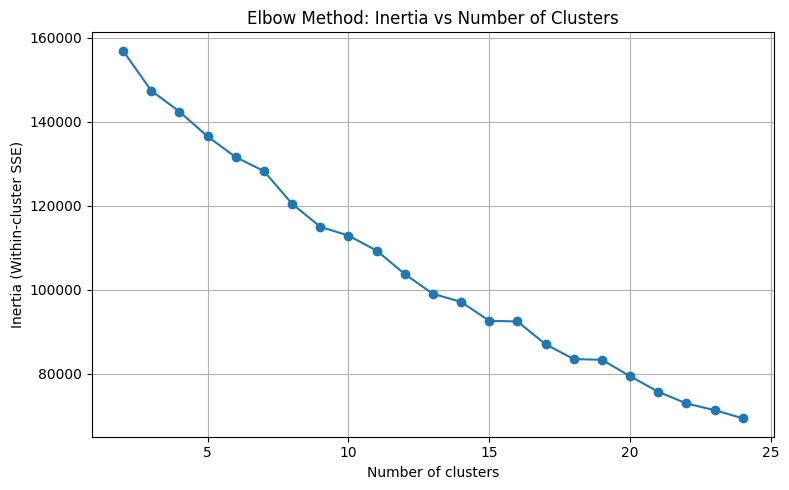

In [5]:
import matplotlib.pyplot as plt

# 4. inertia 
range_n_clusters = range(2, 25)
inertias = []

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=5, max_iter=100)
    kmeans.fit(X_final)
    inertias.append(kmeans.inertia_)

# inertia vs k 
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# 5. cluster
kmeans_final = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_final)
df["Cluster"] = cluster_labels

# 6. model
X_cluster_train, X_cluster_val, y_cluster_train, y_cluster_val = train_test_split(
    X_final, cluster_labels, test_size=0.2, random_state=42
)

cluster_model = RandomForestClassifier(n_estimators=100, random_state=42)
cluster_model.fit(X_cluster_train, y_cluster_train)

# save
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans_final, "kmeans.pkl")
joblib.dump(cluster_model, "cluster_classifier.pkl")

# 8. save for generalization
df[["Index", "Cluster"]].to_csv("train_with_clusters.csv", index=False)
from sklearn.metrics import accuracy_score

y_pred = cluster_model.predict(X_cluster_val)
acc = accuracy_score(y_cluster_val, y_pred)
print(f"Cluster prediction accuracy: {acc:.4f}")


Cluster prediction accuracy: 0.9552


In [7]:
# 7. for each cluster stacking
for c in range(best_n_clusters):
    subgroup = df[df["Cluster"] == c]
    bankrupt_count = subgroup["Bankrupt?"].sum()
    
    if bankrupt_count == 0:
        print(f"Group {c} 没有破产公司，跳过建模。")
        continue

    X_sub = subgroup.drop(columns=["Index", "Bankrupt?", "Cluster"])
    y_sub = subgroup["Bankrupt?"]

    # Base 模型设置
    base_models = [
        ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
        ("lr", LogisticRegression(max_iter=1000, random_state=42)),
        ("l1", LogisticRegression(penalty="l1", solver="liblinear", random_state=42))
    ]
    meta_model = LogisticRegression()
    stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
    stack_model.fit(X_sub, y_sub)

    # 保存子模型
    joblib.dump(stack_model, f"group_{c}_stack_model.pkl")

    # 输出准确度
    y_pred = stack_model.predict(X_sub)
    cm = confusion_matrix(y_sub, y_pred)
    TT = cm[1, 1]
    TF = cm[1, 0]
    acc = TT / (TT + TF) if (TT + TF) > 0 else 0
    print(f"Group {c}: acc = {acc:.4f}, TT = {TT}, TF = {TF}")

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/py

Group 0: acc = 0.0364, TT = 2, TF = 53
Group 1 没有破产公司，跳过建模。


/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/py

Group 2: acc = 0.9857, TT = 138, TF = 2
Group 3 没有破产公司，跳过建模。


/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (1) does not match total number of classes (2). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)